In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql.functions import when, col, date_format, hour
from pyspark.sql import functions as F
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/27 01:30:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/27 01:30:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# read the curated taxi and weather data. Also we need taxi zones data
sdf = spark.read.parquet('../data/curated/*')
zones = spark.read.csv('../data/taxi_zones/taxi+_zone_lookup.csv', \
                       header=True, inferSchema=True)
wsdf = spark.read.parquet('../data/weather_curated/*')
JFK_AIRPORT = 132

In [4]:
wsdf.printSchema()
sdf.printSchema()
zones.printSchema()

root
 |-- station: string (nullable = true)
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- max_temp: double (nullable = true)
 |-- min_temp: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = t

In [5]:
# drop irrelevant columns that we dont need to train the model on
# not relevant for our research question
sdf = sdf.drop('VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', \
                'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', \
                'mta_tax', 'tip_amount', 'tolls_amount', \
                'improvement_surcharge', 'total_amount', \
                'congestion_surcharge', 'airport_fee')
sdf.printSchema()

root
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)



## lets start doing some modelling using weather data
### we will fit linear model and see if these have an affect on weather data

In [6]:
# aggregate taxi data by date and location.
# also convert timestamp to date so we can join with weather data `date`
agg_by_date_loc = (sdf.groupby(date_format('tpep_pickup_datetime', \
                                        'yyyy-MM-dd').alias('pickup_date'), \
                                        'PULocationID') \
                                    .count() \
                                    .withColumnRenamed('count', 'total_trips'))


# Joining with weather data
wsdf2 = agg_by_date_loc.join(wsdf, agg_by_date_loc.pickup_date == wsdf.date, \
                            'inner').drop('pickup_date') 


# now fitting linear regression to see how weather affects taxi demand

In [7]:
df = wsdf2.toPandas()
# Add a constant term to allow statsmodels to fit an intercept
df['const'] = 1

# Predictor variables (weather attributes + location)
predictor_vars = ['const', 'PULocationID', 'avg_wind_speed', 'precipitation', 
                  'snowfall','avg_temp'
]
X = df[predictor_vars]


# Response variable
y = df['total_trips']

model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            total_trips   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     689.2
Date:                Sun, 27 Aug 2023   Prob (F-statistic):               0.00
Time:                        01:31:27   Log-Likelihood:            -8.3023e+05
No. Observations:               99163   AIC:                         1.660e+06
Df Residuals:                   99157   BIC:                         1.661e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            134.6158     13.725      9.

# lets fit linear regression to see wether weekday variable is significant or not

In [8]:
# Extract the day of the week
sdf_with_day = agg_by_date_loc.withColumn("day_of_week",\
                              date_format(col("pickup_date"), "E"))

# Create a new column that represents 1 for weekday and 0 for weekend
sdf_with_weekday = sdf_with_day.withColumn("is_weekday", \
                                            when(col("day_of_week") \
                                            .isin(["Sat", "Sun"]), 0) \
                                            .otherwise(1))
sdf3 = sdf_with_weekday.drop('day_of_week')

df = sdf3.toPandas()
# Add a constant term to allow statsmodels to fit an intercept
df['const'] = 1

# Predictor variables (weather attributes + location)
predictor_vars = ['const', 'PULocationID', 'is_weekday'
]
X = df[predictor_vars]


# Response variable
y = df['total_trips']

model2 = sm.OLS(y, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            total_trips   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1722.
Date:                Sun, 27 Aug 2023   Prob (F-statistic):               0.00
Time:                        01:31:40   Log-Likelihood:            -8.3023e+05
No. Observations:               99163   AIC:                         1.660e+06
Df Residuals:                   99160   BIC:                         1.661e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          143.7717      8.675     16.573   

## In our analysis section we saw that Manhattan has the most taxi demand. JFK airport not being in Manhattan but still have significant demand so while fitting Random forest we will focus on Manhattan area and JFK airport

In [9]:
filtered_zones = zones.filter(
    (F.col("Borough") == "Manhattan") | 
    (F.col("Zone") == "JFK Airport")
)

# Perform the join
filtered_sdf = sdf.join(
    filtered_zones, 
    sdf.PULocationID == filtered_zones.LocationID, 
    "inner"
).drop(filtered_zones.LocationID)

### lets fit Random forest to predict total trips using location ID, significant
### weather data (avg_temp, snowfall), hour of the day

In [10]:
# as we saw from linear regression snowfall and avg temp are significant 
# to predict the number of trips so lets use them as well in our final model

# aggregate by date, hour and location
agg_by_date_hour_loc = (filtered_sdf \
                        .groupby(date_format('tpep_pickup_datetime', \
                                            'yyyy-MM-dd') \
                                            .alias('pickup_date'), \
                                hour('tpep_pickup_datetime') \
                                    .alias('hour_of_day'), \
                                'PULocationID') \
                        .count()
                        .withColumnRenamed('count', 'total_trips'))

# join with weather data
result_sdf = agg_by_date_hour_loc \
            .join(wsdf, agg_by_date_hour_loc.pickup_date == wsdf2.date, \
                'inner')

# now sort the data by date and hour
result_sdf = result_sdf.sort(F.col("pickup_date"), F.col("hour_of_day"))

# drop irrelevant columns
drop_col = ['station', 'name', 'date', 'avg_wind_speed', 
            'precipitation', 'max_temp', 'min_temp'
]
result_sdf = result_sdf.drop(*drop_col)

In [11]:
result_sdf.show(1, vertical = True)

-RECORD 0------------------
 pickup_date  | 2022-02-01 
 hour_of_day  | 0          
 PULocationID | 100        
 total_trips  | 15         
 snowfall     | 0.0        
 avg_temp     | -2.9       
only showing top 1 row



In [12]:
# now split the data for training and testing
# training data spans from Feb 2022 to Jan 2023
# testing data spans from Feb 2023 to May 2023
train_sdf = result_sdf.filter((F.col("pickup_date") >= "2022-02-01") & 
                            (F.col("pickup_date") <= "2023-01-31"))

test_sdf = result_sdf.filter((F.col("pickup_date") >= "2023-02-01") & 
                           (F.col("pickup_date") <= "2023-05-31"))

train = train_sdf.count()
test = test_sdf.count()
print(train)
print(test)
print(f"{train/(test+train)*100}%")
# drop pickup date dont need this for our model
train_sdf = train_sdf.drop('pickup_date')
test_sdf = test_sdf.drop('pickup_date')

507436
165578
75.39754002145573%


### LGTM! we have 75 to 25 split for train and test data

In [13]:
# data size is not much larger can use pandas to fit the model
train_df = train_sdf.toPandas()
test_df = test_sdf.toPandas()

# For the training data:
X_train = train_df.drop("total_trips", axis=1)  # Features
y_train = train_df["total_trips"]               # Response variable

# For the test data:
X_test = test_df.drop("total_trips", axis=1)    # Features
y_test = test_df["total_trips"]                 # Response variable

In [14]:
# using Grid search lets find the best paramters for our model and then
# fit the model on the training data 

param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 4]
}

rfr = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 30}


In [15]:
# calculate the rmse on training and test data
best_rfr = grid_search.best_estimator_
y_train_pred = best_rfr.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"RMSE on training data = {train_rmse}")


y_test_pred = best_rfr.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE on test data = {test_rmse}")

RMSE on training data = 24.3541916936064
RMSE on test data = 35.74732856351276


In [16]:
def plot_graph(y_pred, y_actual, X_vals, loc_ID, output_dir):
    """ This function plots the actual and predicted values for a given
    location ID. It also saves the plot in the output directory.
    `y_pred` is pandas series of predicted values, y_actual is pandas series
    of actual values, X_vals is pandas dataframe of predictor variables,
    `loc_ID` is int. if loc_ID is 0, then plot is for all locations, if loc_ID
    is 132 (JFK_AIRPORT), then plot is for JFK airport, else plot is for 
    Manhattan.
    """

    predictions = y_pred
    area_name = ''

    # Create a new DataFrame to hold hour_of_day, actual and predicted trips
    # Keep 'hour_of_day' and 'PULocationID'
    result_df = X_vals[['hour_of_day', 'PULocationID']].copy()
    result_df['actual_trips'] = y_actual.values
    result_df['predicted_trips'] = predictions

    if (loc_ID == 0):
        location_specific_df = result_df
    elif (loc_ID == 132):
        # Filter for only rows where PULocationID is 132
        location_specific_df = result_df[result_df['PULocationID'] == loc_ID]
        area_name = 'for JFK Airport'
    else:
        # Filter for only rows where PULocationID is not 132 (Manhattan area)
        location_specific_df = result_df[result_df['PULocationID'] \
                                         != JFK_AIRPORT]
        area_name = 'for Manhattan'
    

    # Group by 'hour_of_day' and calculate the sum of 'total_trips' for actual 
    # and predicted
    grouped = location_specific_df.groupby('hour_of_day').agg({
        'actual_trips': 'sum',
        'predicted_trips': 'sum'
    }).reset_index()

    # Plotting
    plt.figure(figsize=(12, 6))

    # Actual values
    plt.plot(grouped['hour_of_day'], grouped['actual_trips'], label='Actual', \
            color='blue')

    # Predicted values
    plt.plot(grouped['hour_of_day'], grouped['predicted_trips'], \
            label='Predicted', color='red', linestyle='--')

    plt.xticks(range(0, 25, 3))

    plt.title('Actual vs. Predicted Taxi Trips per Hour ' + area_name)
    plt.xlabel('Hour of Day')
    plt.ylabel('Total Trips')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # save plot
    plt.savefig(output_dir + '.png')
    plt.show()

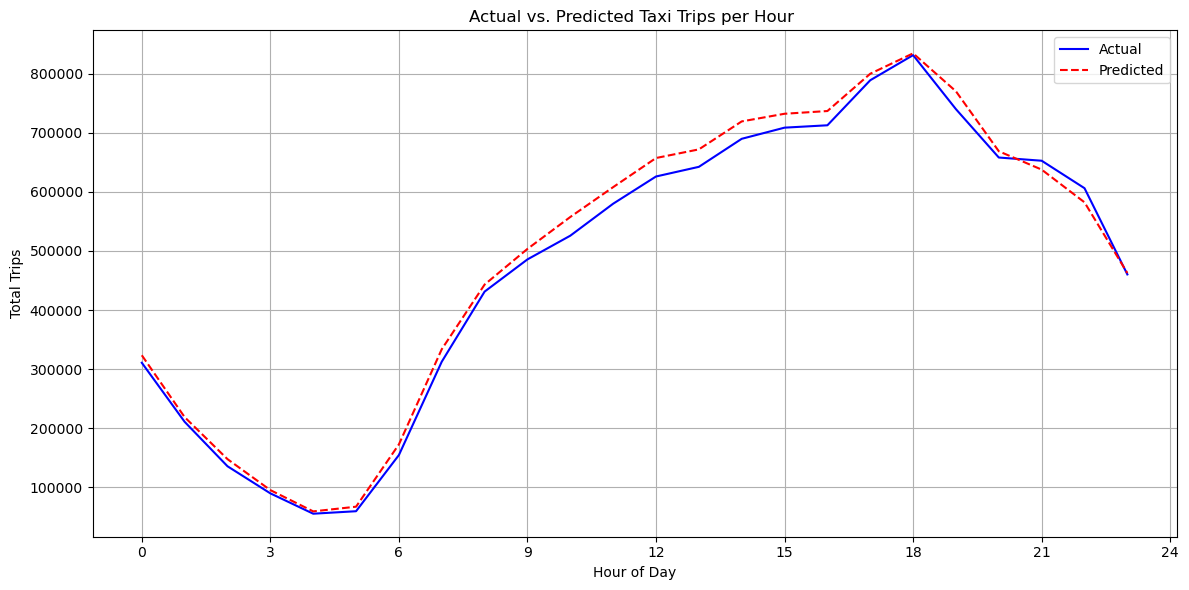

In [17]:
# plot for all locations
plot_graph(y_test_pred, y_test, X_test, 0, '../plots/actual_vs_pred_overall')

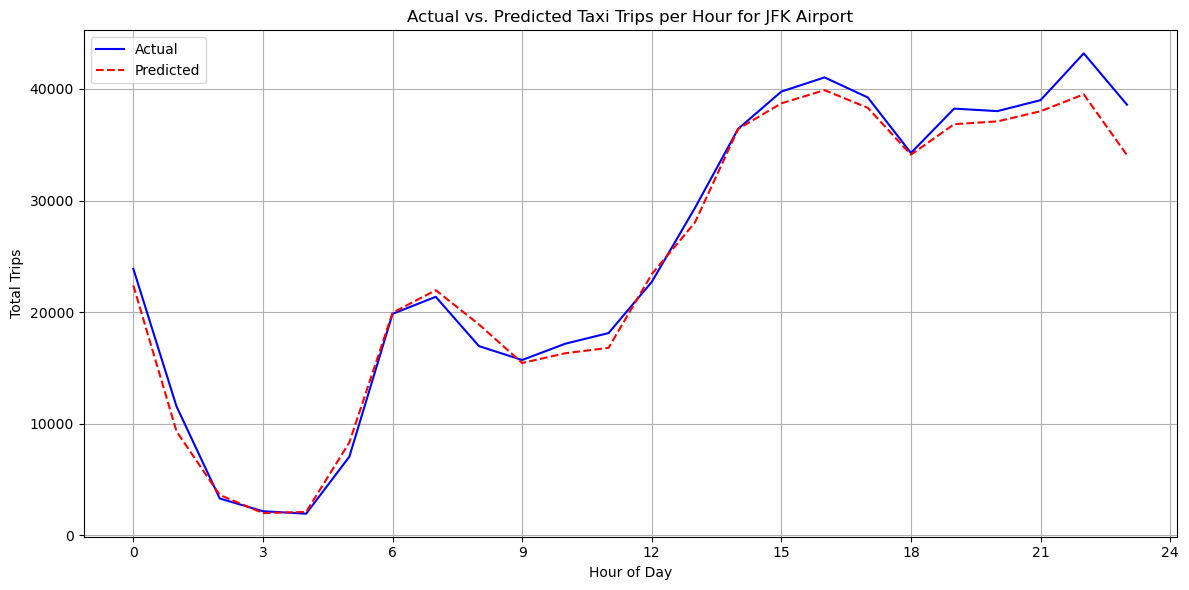

In [18]:
# plot for JFK airport
plot_graph(y_test_pred, y_test, X_test, JFK_AIRPORT, 
            '../plots/actual_vs_pred_JFK')

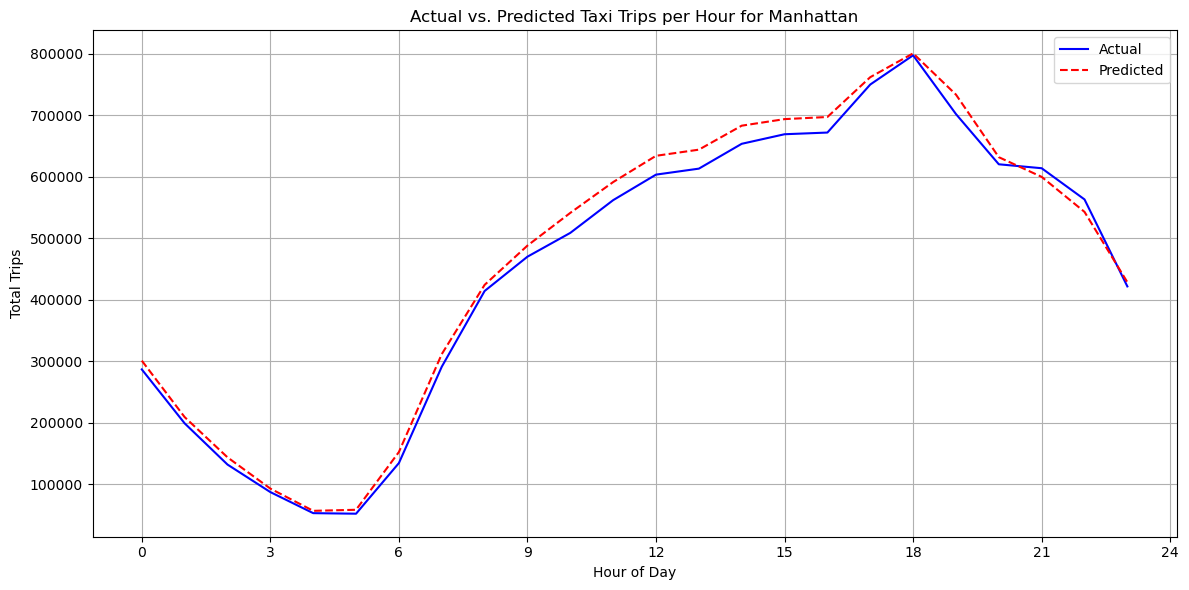

In [19]:
# plot for Manhattan
plot_graph(y_test_pred, y_test, X_test, JFK_AIRPORT-1, 
            '../plots/actual_vs_pred_Manhattan' )